# Sintetic Data Factory for Route Optimization in a Delivery Company
# Author: [Juan Andrés Méndez Galvis](https://github.com/jabandersnatch)


> What is the Factory design pattern?

<i>The Factory Method Pattern defines an interface for creating an object, but lets subclasses decide which class to instantiate. Factory Method lets a class defer instantiation to subclasses. (Gang of Four)</i>

> How can we use the Factory design pattern to build sintetic data?

<i>We can use the Factory design pattern to create a set of classes that generate data for different scenarios. In this case, we will create a set of classes that generate data for a delivery company. We will create a class for each type of data that we want to generate, such as clients, products, routes, etc. Each class will have a method that generates the data. We will then create a factory class that will create instances of these classes and call their methods to generate the data. </i>


In [1]:
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
import geopandas as gpd
from concurrent.futures import ThreadPoolExecutor
import folium
from folium.plugins import MarkerCluster
from shapely.validation import explain_validity



# CRVP Sintetic Data Factory
This notebook is a sintetic data factory for a delivery company. The factory generates data for clients, products, routes, and vehicles. The data is generated using random values and patterns that are common in the delivery industry. The factory uses the Factory design pattern to create instances of classes that generate the data. The factory then calls the methods of these classes to generate the data. The data is stored in a pandas DataFrame and saved to a CSV file.

In [2]:
class CVRPSyntheticDataFactory:
    def __init__(self, depots, city_boundary, vehicle_params, config, seed=None):
        """
        Initialize the synthetic data factory for CVRP.

        Parameters:
        - depots: List of tuples [(longitude, latitude), ...] representing depot locations.
        - city_boundary: GeoDataFrame or Shapely Polygon defining the operational city boundary.
        - vehicle_params: Dictionary defining vehicle types with their capacities, ranges, and counts.
        - config: Dictionary containing fine-tuning parameters.
        - seed: Integer seed for random number generator to ensure reproducibility.
        """
        self.depots = depots
        self.city_boundary = city_boundary
        self.vehicle_params = vehicle_params
        self.config = config
        self.random_state = np.random.RandomState(seed)

        # Prepare depots and city boundary in projected coordinate system
        self._prepare_geometries()

        # Initialize recharge nodes
        self.recharge_nodes = None

        # Initialize depot capacities
        self.depot_capacities = None

    def _prepare_geometries(self):
        """
        Prepare depots and city boundary by projecting them into a metric coordinate system.
        """
        # Convert depots to GeoDataFrame
        depots_gdf = gpd.GeoDataFrame(
            {'geometry': [Point(lon, lat) for lon, lat in self.depots]},
            crs='EPSG:4326'
        )
        # Convert city boundary to GeoDataFrame if it's a Polygon
        if isinstance(self.city_boundary, Polygon):
            self.city_boundary = gpd.GeoDataFrame(
                {'geometry': [self.city_boundary]},
                crs='EPSG:4326'
            )
        elif isinstance(self.city_boundary, gpd.GeoSeries):
            self.city_boundary = gpd.GeoDataFrame(geometry=self.city_boundary)
            self.city_boundary.crs = 'EPSG:4326'

        # Project to UTM for distance calculations
        utm_crs = self.city_boundary.estimate_utm_crs()
        self.city_boundary = self.city_boundary.to_crs(utm_crs)
        self.depots_gdf = depots_gdf.to_crs(utm_crs)

        # Extract coordinates for use in client generation
        self.depots_coords = np.array(
            [(geom.x, geom.y) for geom in self.depots_gdf.geometry]
        )
        self.city_boundary_polygon = self.city_boundary.union_all()
        self.minx, self.miny, self.maxx, self.maxy = self.city_boundary.total_bounds

    def generate_recharge_nodes(self, num_recharge_nodes, starting_location_id):
        """
        Generate recharge nodes within the city boundary.

        Parameters:
        - num_recharge_nodes: Integer specifying the number of recharge nodes to generate.
        - starting_location_id: Integer specifying the starting LocationID for recharge nodes.

        Returns:
        - recharge_nodes_df: Pandas DataFrame containing recharge node IDs and locations.
        """
        recharge_nodes = []
        attempts = 0
        max_attempts = num_recharge_nodes * 10  # To prevent infinite loops

        while len(recharge_nodes) < num_recharge_nodes and attempts < max_attempts:
            # Generate random points within the city's bounding box
            x = self.random_state.uniform(self.minx, self.maxx)
            y = self.random_state.uniform(self.miny, self.maxy)
            point = Point(x, y)
            if self.city_boundary_polygon.contains(point):
                recharge_nodes.append({
                    'RechargeNodeID': len(recharge_nodes) + 1,
                    'LocationID': starting_location_id + len(recharge_nodes),  # Assign unique LocationID
                    'X': x,
                    'Y': y
                })
            attempts += 1

        if len(recharge_nodes) < num_recharge_nodes:
            raise ValueError(f"Could not generate the required number of recharge nodes after {max_attempts} attempts.")

        recharge_nodes_df = pd.DataFrame(recharge_nodes)

        # Convert coordinates back to longitude and latitude
        recharge_nodes_gdf = gpd.GeoDataFrame(
            recharge_nodes_df,
            geometry=gpd.points_from_xy(recharge_nodes_df['X'], recharge_nodes_df['Y']),
            crs=self.city_boundary.crs
        )
        recharge_nodes_gdf = recharge_nodes_gdf.to_crs('EPSG:4326')
        recharge_nodes_df['Longitude'] = recharge_nodes_gdf.geometry.x
        recharge_nodes_df['Latitude'] = recharge_nodes_gdf.geometry.y
        recharge_nodes_df.drop(columns=['X', 'Y'], inplace=True)

        self.recharge_nodes = recharge_nodes_df
        return recharge_nodes_df

    def generate_clients(self, num_clients):
        """
        Generate client nodes with locations and demands within the city boundary.

        Parameters:
        - num_clients: Integer specifying the number of client nodes to generate.

        Returns:
        - clients_df: Pandas DataFrame containing client IDs, LocationIDs, locations, and demands.
        """
        clients = []
        # Configuration parameters
        location_mean = self.config.get('client_location_mean', 5000)
        location_std = self.config.get('client_location_std', 2000)
        max_attempts = 1000

        # Determine if recharge nodes are available
        recharge_nodes_enabled = 'num_recharge_nodes' in self.config

        # Get product demand distributions
        product_demands = self.config.get('product_demands', {
            'Product1': {
                'type': 'uniform',
                'parameters': {'low': 1, 'high': 10}
            }
        })
        product_list = list(product_demands.keys())

        # Calculate the starting LocationID for clients
        starting_location_id = len(self.depots) + 1

        def create_client(client_id):
            attempts = 0
            while attempts < max_attempts:
                # Choose a depot randomly
                depot_idx = self.random_state.choice(len(self.depots_coords))
                depot_x, depot_y = self.depots_coords[depot_idx]

                # Generate distance from depot
                distance = abs(self.random_state.normal(loc=location_mean, scale=location_std))

                # Adjust distance to ensure that some routes require recharge nodes
                if recharge_nodes_enabled and client_id % 10 == 0:
                    # Increase distance beyond vehicle range to require recharge
                    distance_multiplier = self.config.get('distance_multiplier', 2.0)
                    distance *= distance_multiplier

                # Generate angle
                angle = self.random_state.uniform(0, 2 * np.pi)

                # Calculate client location
                x = depot_x + distance * np.cos(angle)
                y = depot_y + distance * np.sin(angle)

                point = Point(x, y)
                if self.city_boundary_polygon.contains(point):
                    # Assign demands for each product
                    demands = {}
                    for product, dist_config in product_demands.items():
                        demand = self.generate_demand(dist_config, distance)
                        demands[product] = demand
                    client_data = {
                        'ClientID': client_id,
                        'LocationID': starting_location_id + client_id - 1,  # Assign unique LocationID
                        'DepotID': depot_idx + 1,
                        'X': x,
                        'Y': y,
                        **demands
                    }
                    return client_data
                attempts += 1
            raise ValueError(f"Could not generate a client within the city boundary after {max_attempts} attempts.")

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(create_client, cid) for cid in range(1, num_clients + 1)]
            for future in futures:
                clients.append(future.result())

        clients_df = pd.DataFrame(clients)

        # Convert coordinates back to longitude and latitude
        clients_gdf = gpd.GeoDataFrame(
            clients_df, geometry=gpd.points_from_xy(clients_df['X'], clients_df['Y']),
            crs=self.city_boundary.crs
        )
        clients_gdf = clients_gdf.to_crs('EPSG:4326')
        clients_df['Longitude'] = clients_gdf.geometry.x
        clients_df['Latitude'] = clients_gdf.geometry.y

        clients_df.drop(columns=['X', 'Y'], inplace=True)

        return clients_df


    def generate_demand(self, distribution_config, distance=None):
        """
        Generate a demand value based on the specified probability distribution.

        Parameters:
        - distribution_config: Dictionary specifying the distribution type and parameters.
        - distance: Float representing the distance from the depot (optional).

        Returns:
        - demand: Integer demand value.
        """
        dist_type = distribution_config.get('type', 'uniform')
        params = distribution_config.get('parameters', {})

        low = params.get('low', 1)
        high = params.get('high', np.inf)

        if dist_type == 'uniform':
            demand = self.random_state.randint(low, high + 1)
        elif dist_type == 'normal':
            mean = params.get('mean', 5)
            std = params.get('std', 2)
            demand = int(abs(self.random_state.normal(mean, std)))
        elif dist_type == 'poisson':
            lam = params.get('lam', 5)
            demand = self.random_state.poisson(lam)
        else:
            raise ValueError(f"Unsupported demand distribution type: {dist_type}")

        # Adjust demand based on distance (clients farther away may have higher demands)
        if distance:
            max_distance = self.config.get('max_distance', 20000)
            demand_multiplier = 1 + (distance / max_distance)
            demand = int(demand * demand_multiplier)

        demand = max(low, min(demand, high))
        return demand

    def generate_vehicles(self):
        """
        Generate vehicle information based on provided vehicle parameters.

        Returns:
        - vehicles_df: Pandas DataFrame containing vehicle types, capacities, ranges.
        """
        vehicles = []
        for vehicle_type, params in self.vehicle_params.items():
            mean_capacity = params['capacity']
            mean_range = params['range']
            count = params['count']

            # Standard deviations are configurable
            std_capacity = mean_capacity * self.config.get('vehicle_capacity_std', 0.2)
            std_range = mean_range * self.config.get('vehicle_range_std', 0.2)

            for _ in range(count):
                capacity = self.random_state.normal(mean_capacity, std_capacity)
                capacity = max(1, capacity)

                range_ = self.random_state.normal(mean_range, std_range)
                range_ = max(1, range_)

                vehicles.append({
                    'VehicleType': vehicle_type,
                    'Capacity': capacity,
                    'Range': range_
                })

        vehicles_df = pd.DataFrame(vehicles)
        return vehicles_df

    def get_depots(self):
        """
        Get depot information.

        Returns:
        - depots_df: Pandas DataFrame containing depot IDs, LocationIDs, and locations.
        """
        depots_gdf = self.depots_gdf.to_crs('EPSG:4326')
        depots_data = [{
            'DepotID': idx + 1,
            'LocationID': idx + 1,  # Assign LocationID same as DepotID
            'Longitude': geom.x,
            'Latitude': geom.y
        } for idx, geom in enumerate(depots_gdf.geometry)]

        depots_df = pd.DataFrame(depots_data)
        return depots_df


    def distribute_supply_across_depots(self, total_demands):
        """
        Distribute total supply across depots based on a specified probability distribution.
        """
        num_depots = len(self.depots)
        # Get supply overhead percentage
        overhead_pct = self.config.get('supply_overhead_percentage', 0.2)  # Default to 20% overhead
        total_supply = {product: demand * (1 + overhead_pct) for product, demand in total_demands.items()}

        # Distribute supply across depots
        supply_distribution = self.config.get('supply_distribution', {
            'type': 'uniform',
            'parameters': {}
        })

        depot_supplies = []
        for product in total_supply:
            dist_type = supply_distribution.get('type', 'uniform')
            params = supply_distribution.get('parameters', {})
            if dist_type == 'uniform':
                # Assign equal probabilities
                probabilities = np.ones(num_depots) / num_depots
            elif dist_type == 'dirichlet':
                # Dirichlet distribution for proportions
                alpha = params.get('alpha', np.ones(num_depots))
                if len(alpha) != num_depots:
                    raise ValueError(f"Length of 'alpha' parameter ({len(alpha)}) must match number of depots ({num_depots}).")
                probabilities = self.random_state.dirichlet(alpha)
            else:
                raise ValueError(f"Unsupported supply distribution type: {dist_type}")

            product_supply = self.random_state.multinomial(int(total_supply[product]), probabilities)
            depot_supplies.append(product_supply)

        # Construct depot capacities DataFrame
        depot_capacities = pd.DataFrame({
            'DepotID': np.arange(1, num_depots + 1)
        })

        for idx, product in enumerate(total_supply.keys()):
            depot_capacities[product] = depot_supplies[idx]

        self.depot_capacities = depot_capacities

    def generate_dataset(self):
        """
        Generate the complete dataset including depots, clients, vehicles, and optional recharge nodes.

        Returns:
        - dataset: Dictionary containing DataFrames for depots, clients, vehicles, and recharge nodes (optional).
        """
        depots_df = self.get_depots()
        vehicles_df = self.generate_vehicles()

        # Calculate the number of clients
        total_vehicles = len(vehicles_df)
        client_vehicle_ratio = self.config.get('client_vehicle_ratio', 5.0)
        num_clients = int(total_vehicles * client_vehicle_ratio)

        clients_df = self.generate_clients(num_clients)

        clients_df.drop(columns=['DepotID'], inplace=True)

        # Calculate the starting LocationID for recharge nodes
        starting_location_id = len(depots_df) + len(clients_df) + 1

        # Initialize dataset with depots, clients, and vehicles
        dataset = {
            'Depots': depots_df,
            'Clients': clients_df,
            'Vehicles': vehicles_df
        }

        # Generate recharge nodes only if 'num_recharge_nodes' is specified
        if 'num_recharge_nodes' in self.config:
            num_recharge_nodes = self.config['num_recharge_nodes']
            recharge_nodes_df = self.generate_recharge_nodes(num_recharge_nodes, starting_location_id)
            dataset['RechargeNodes'] = recharge_nodes_df

        # Handle supply limits if enabled
        if self.config.get('enable_supply_limits', False):
            # Calculate total demand for each product
            product_columns = [col for col in clients_df.columns if col in self.config.get('product_demands', {})]
            total_demands = clients_df[product_columns].sum().to_dict()
            self.distribute_supply_across_depots(total_demands)
            dataset['DepotCapacities'] = self.depot_capacities

        return dataset


    @staticmethod
    def save_dataset_to_csv(dataset, directory_path):
        """
        Save the dataset to CSV files in the specified directory.

        Parameters:
        - dataset: Dictionary containing DataFrames to save.
        - directory_path: String specifying the directory where CSV files will be saved.
        """
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
        for key, df in dataset.items():
            file_path = os.path.join(directory_path, f"{key}.csv")
            df.to_csv(file_path, index=False)
        print(f"Dataset saved to {directory_path}")

    @staticmethod
    def load_dataset_from_csv(directory_path):
        """
        Load the dataset from CSV files in the specified directory.

        Parameters:
        - directory_path: String specifying the directory from which CSV files will be loaded.

        Returns:
        - dataset: Dictionary containing DataFrames loaded from CSV files.
        """
        dataset = {}
        for file_name in os.listdir(directory_path):
            if file_name.endswith('.csv'):
                key = file_name.replace('.csv', '')
                file_path = os.path.join(directory_path, file_name)
                df = pd.read_csv(file_path)
                dataset[key] = df
        print(f"Dataset loaded from {directory_path}")
        return dataset


The `plot_data` function creates an interactive map using Folium to visualize depots, clients, and recharge nodes within a city boundary, including extra details like depot capacities and client demands if available.

Here’s how the function works:

1. **Center the Map**: It centers the map on the city boundary's centroid and ensures the city boundary is in the correct coordinate system.
2. **Plot Depots**: For each depot, it adds a red marker with capacity information (if provided in `DepotCapacities`). The popup shows the depot ID and, if applicable, capacities for different products.
3. **Plot Clients**: Clients are shown with blue markers in a `MarkerCluster` to reduce clutter. Popups show each client’s demands per product, if available.
4. **Plot Recharge Nodes**: If recharge nodes are in the dataset, they are added with green markers and labeled with their node IDs.
5. **Layer Control**: A control panel allows toggling between layers on the map.

### Example Usage

To use this function, ensure your data is structured as a dictionary containing data for depots, clients, and recharge nodes (if applicable). Here's an example of preparing and using `plot_data`:

```python
import geopandas as gpd
import pandas as pd

# Sample data setup
df_depots = pd.DataFrame({
    'DepotID': [1, 2],
    'Latitude': [4.6097, 4.6377],
    'Longitude': [-74.0817, -74.0628]
})
clients_df = pd.DataFrame({
    'ClientID': [1, 2, 3],
    'Latitude': [4.6527, 4.6351, 4.6145],
    'Longitude': [-74.0702, -74.0624, -74.0867],
    'ProductA': [100, 150, 200]
})
vehicles_df = pd.DataFrame()  # Example empty DataFrame for other datasets

# Load a sample city boundary (assuming you have a GeoDataFrame city_boundary)
city_boundary = gpd.read_file('path/to/city_boundary.geojson')

# Organize data in a dictionary
dataset = {
    'Depots': df_depots,
    'Clients': clients_df,
    'Vehicles': vehicles_df,
    # Optionally, include 'DepotCapacities' or 'RechargeNodes' if available
}

# Plot the data on the map
m = plot_data(dataset, city_boundary=city_boundary)
m.save('interactive_map.html')  # Save map as HTML file
```

If you're using a load function like `load_dataset` from a CVRP (Capacitated Vehicle Routing Problem) dataset, load the data as follows:

```python
dataset = load_dataset('CVRP_data_file.csv')  # Load all data at once
plot_data(dataset, city_boundary)
```

In this way, `plot_data` visualizes data interactively, helping you see depot, client, and recharge node placements and their associated information.

In [30]:
def plot_data(dataset, city_boundary):
    """
    Plot the depots, clients, and recharge nodes on an interactive map using Folium.
    Includes depot capacities and client demands per product when available.
    Adapts to the absence of recharge nodes (e.g., when num_recharge_nodes is 0).
    """
    # Ensure the city boundary is in the correct coordinate reference system
    if city_boundary.crs != 'EPSG:4326':
        city_boundary = city_boundary.to_crs('EPSG:4326')
    
    # Project the city boundary to a projected CRS for accurate centroid calculation
    projected_crs = city_boundary.estimate_utm_crs()
    projected_city_boundary = city_boundary.to_crs(projected_crs)
    city_center_point = projected_city_boundary.geometry.centroid.iloc[0]
    
    # Convert the centroid back to latitude and longitude
    city_center_latlon = gpd.GeoSeries([city_center_point], crs=projected_crs).to_crs('EPSG:4326').geometry.iloc[0]
    
    # Create a base map centered around the city boundary centroid
    m = folium.Map(location=[city_center_latlon.y, city_center_latlon.x], zoom_start=12)
    
    # Merge depot capacities if available
    depots_df = dataset['Depots'].copy()
    if 'DepotCapacities' in dataset:
        depot_capacities_df = dataset['DepotCapacities']
        # Merge capacities into depots DataFrame
        depots_df = depots_df.merge(depot_capacities_df, on='DepotID', how='left')
    
    # Plot depots with capacity information if available
    for _, row in depots_df.iterrows():
        # Build popup content
        popup_content = f"<b>Depot {row['DepotID']}</b>"
        # Add capacities per product if available
        if 'DepotCapacities' in dataset:
            capacity_columns = depot_capacities_df.columns.tolist()
            product_columns = [col for col in capacity_columns if col != 'DepotID']
            if product_columns:
                popup_content += "<br><b>Capacities:</b>"
                for product in product_columns:
                    capacity = row.get(product, 'N/A')
                    popup_content += f"<br>{product}: {capacity}"
        else:
            # If DepotCapacities not available, do nothing or add default message
            pass
        
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_content, max_width=300),
            icon=folium.Icon(color='red', icon='home', prefix='fa')
        ).add_to(m)
    
    # Use MarkerCluster for clients to improve visualization
    client_cluster = MarkerCluster(name='Clients').add_to(m)
    
    # Get product columns in clients DataFrame
    clients_df = dataset['Clients'].copy()
    known_columns = ['ClientID', 'DepotID', 'Longitude', 'Latitude']
    product_columns = [col for col in clients_df.columns if col not in known_columns]
    
    # Plot clients with demands per product
    for _, row in clients_df.iterrows():
        # Build popup content
        popup_content = f"<b>Client {row['ClientID']}</b>"
        if product_columns:
            popup_content += "<br><b>Demands:</b>"
            for product in product_columns:
                demand = row.get(product, 'N/A')
                popup_content += f"<br>{product}: {demand}"
        else:
            # Fallback if no product demands are present
            demand = row.get('Demand', 'N/A')
            popup_content += f"<br>Demand: {demand}"
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=folium.Popup(popup_content, max_width=300),
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(client_cluster)
    
    # Plot recharge nodes if they exist in the dataset and are not empty
    if 'RechargeNodes' in dataset and not dataset['RechargeNodes'].empty:
        for _, row in dataset['RechargeNodes'].iterrows():
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=folium.Popup(f"<b>Recharge Node {row['RechargeNodeID']}</b>", max_width=200),
                icon=folium.Icon(color='green', icon='bolt', prefix='fa')
            ).add_to(m)
    else:
        # If RechargeNodes is not present or is empty, we can either do nothing or add a message
        pass
    
    # Add a layer control panel to toggle layers
    folium.LayerControl().add_to(m)
    
    return m

## Auxiliary function to check and fix geometries for the geojson file
This auxiliary function, `check_and_fix_geometries`, is designed to validate and correct geometry data within a GeoDataFrame, specifically targeting cases where geometries may be invalid due to topological issues like self-intersections or unclosed rings. Ensuring valid geometries is essential for accurate spatial analysis, as invalid geometries can cause errors or inaccuracies in geospatial operations.

In [31]:
def check_and_fix_geometries(city_boundary):
    """
    Check and fix invalid geometries in the GeoDataFrame.

    Parameters:
    - city_boundary: GeoDataFrame containing the city boundary or areas.

    Returns:
    - valid_city_boundary: GeoDataFrame with fixed geometries.
    """
    # Check for invalid geometries
    invalid_geometries = city_boundary[~city_boundary.is_valid]
    
    if len(invalid_geometries) > 0:
        print(f"Found {len(invalid_geometries)} invalid geometries.")
        
        # Explain the reason for invalid geometries
        for idx, row in invalid_geometries.iterrows():
            print(f"Invalid geometry at index {idx}: {explain_validity(row.geometry)}")

        # Attempt to fix invalid geometries using buffer(0) trick
        city_boundary['geometry'] = city_boundary['geometry'].buffer(0)

        # Re-check if any geometries are still invalid after fixing
        still_invalid = city_boundary[~city_boundary.is_valid]
        if len(still_invalid) > 0:
            print("Some geometries could not be fixed automatically.")
        else:
            print("All geometries have been fixed.")
    
    return city_boundary


## `generate_depots` function
The `generate_depots` function creates a specified number of depot locations evenly spaced within a given city boundary. Here’s a step-by-step of how it works:

1. **Prepare the Boundary**: It ensures the city boundary has valid geometry, then merges any multiple areas into one continuous shape.
2. **Switch to Metric System**: Converts the boundary to a coordinate system that measures in meters, making it easier to work with distances.
3. **Grid Generation**: Inside the city’s bounding box, it creates a grid of points with spacing based on the city’s area and the number of depots.
4. **Filter Points**: Only keeps grid points that fall inside the city boundary.
5. **Select Depots**: Randomly shuffles and selects a subset of points to be used as depot locations.
6. **Convert Back to Latitude and Longitude**: Changes the selected points from metric coordinates back to latitude and longitude.

The result is a list of depot coordinates evenly spaced within the city boundary.

In [25]:
from shapely.geometry import Point
import numpy as np
import geopandas as gpd

def generate_depots(city_boundary, n_depots, seed=None):
    """
    Generate n_depots depots evenly spaced within the city boundary.

    Parameters:
    - city_boundary: GeoDataFrame with valid geometries.
    - n_depots: Number of depots to generate.
    - seed: Random seed for reproducibility.

    Returns    'RechargeNodes': recharge_nodes_df,:
    - depots: List of tuples [(longitude, latitude), ...] representing depot locations.
    """
    # Copy city_boundary to avoid modifying the original
    city_boundary = city_boundary.copy()

    # Fix invalid geometries if any
    city_boundary['geometry'] = city_boundary['geometry'].buffer(0)

    # Merge all polygons into a single polygon
    city_polygon = city_boundary.union_all()

    # Project to a metric CRS (e.g., UTM) for distance calculations
    utm_crs = city_boundary.estimate_utm_crs()
    city_polygon_utm = gpd.GeoSeries([city_polygon], crs=city_boundary.crs).to_crs(utm_crs).iloc[0]

    # Get the bounding box of the city polygon
    minx, miny, maxx, maxy = city_polygon_utm.bounds

    # Estimate grid spacing based on the desired number of depots
    total_area = city_polygon_utm.area
    num_points = n_depots * 10  # Generate more points to ensure enough within the polygon
    grid_spacing = np.sqrt(total_area / num_points)
    dx = dy = grid_spacing

    # Generate grid points within the bounding box
    x_points = np.arange(minx, maxx, dx)
    y_points = np.arange(miny, maxy, dy)
    grid_x, grid_y = np.meshgrid(x_points, y_points)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    # Convert grid points to shapely Point objects
    points = [Point(xy) for xy in grid_points]

    # Keep only points that are within the city polygon
    points_within_polygon = [point for point in points if city_polygon_utm.contains(point)]

    # Shuffle the points to ensure randomness
    random_state = np.random.RandomState(seed)
    random_state.shuffle(points_within_polygon)

    # Evenly select depots from the list of points
    total_points = len(points_within_polygon)
    if total_points < n_depots:
        raise ValueError("Not enough points within the polygon to select depots.")
    else:
        indices = np.linspace(0, total_points - 1, n_depots, dtype=int)
        selected_points = [points_within_polygon[i] for i in indices]

    # Convert the selected points back to latitude and longitude
    selected_points_gdf = gpd.GeoDataFrame(geometry=selected_points, crs=utm_crs)
    selected_points_gdf = selected_points_gdf.to_crs('EPSG:4326')

    depots = [(point.x, point.y) for point in selected_points_gdf.geometry]

    return depots




To use the `CVRPSyntheticDataFactory` class effectively, here’s a quick guide to understand the data and variables required for initialization and generating synthetic datasets for a Capacitated Vehicle Routing Problem (CVRP):

### Step-by-Step Guide

#### 1. **Prepare Depot Locations**
   - **Input Format:** A list of `(longitude, latitude)` tuples representing the geographic locations of depots.
   - **Example:** `depots = [(lon1, lat1), (lon2, lat2), ...]`

#### 2. **Define City Boundary**
   - **Requirement:** The boundary of the city where the CVRP operates, provided as a `GeoDataFrame` or a `Polygon`.
   - **Purpose:** Ensures that generated data falls within the city’s area.
   - **Example:** `city_boundary = gpd.GeoDataFrame` with the city boundary polygon.

#### 3. **Set Vehicle Parameters**
   - **Input Format:** A dictionary that specifies vehicle types, their capacities, ranges, and counts.
   - **Purpose:** Defines the available vehicle types and their characteristics (e.g., capacity and range).
   - **Example:**
     ```python
     vehicle_params = {
         'Gas Car': {'capacity': 120, 'range': 150, 'count': 50},
         'EV': {'capacity': 96, 'range': 1000, 'count': 25},
         'drone': {'capacity': 25, 'range': 15, 'count': 70}
     }
     ```

#### 4. **Set Configuration Parameters**
   - **Input Format:** A dictionary containing parameters for client generation, product demand distribution, and supply limits.
   - **Key Parameters:**
     - `client_location_mean` and `client_location_std`: Controls client distance from depots.
     - `client_vehicle_ratio`: Number of clients per vehicle.
     - `product_demands`: Defines demand distribution for each product (e.g., normal, poisson).
     - `enable_supply_limits`: Whether to impose supply limits across depots.
     - `supply_overhead_percentage`: Extra supply percentage for each depot.
   - **Example:**
     ```python
     config = {
         'client_location_mean': 5000,
         'client_location_std': 3000,
         'client_vehicle_ratio': 50,
         'product_demands': {
             'Product-Type-A': {'type': 'poisson', 'parameters': {'lam': 13, 'low': 2, 'high': 12}},
             'Product-Type-B': {'type': 'normal', 'parameters': {'mean': 5, 'std': 2, 'low': 1, 'high': 10}},
             'Product-Type-C': {'type': 'uniform', 'parameters': {'low': 1, 'high': 10}}
         },
         'enable_supply_limits': True,
         'supply_overhead_percentage': 0.12,
         'supply_distribution': {'type': 'dirichlet', 'parameters': {'alpha': [1] * len(depots)}},
         'num_recharge_nodes': 24
     }
     ```

#### 5. **Initialize the Factory and Generate Data**
   - **Initialization:** Create an instance of `CVRPSyntheticDataFactory`.
   - **Example:**
     ```python
     factory = CVRPSyntheticDataFactory(depots, city_boundary, vehicle_params, config, seed=42)
     ```

#### 6. **Generate the Dataset**
   - Call `generate_dataset()` to create the synthetic dataset, which includes `Depots`, `Clients`, `Vehicles`, and optionally `RechargeNodes` and `DepotCapacities`.
   - **Accessing DataFrames:** Use dictionary keys (`'Depots'`, `'Clients'`, etc.) to access each part of the dataset.
   - **Example:**
     ```python
     dataset = factory.generate_dataset()
     depots_df = dataset['Depots']
     clients_df = dataset['Clients']
     ```

### Notes
- **Seed:** Setting the seed ensures reproducibility of the dataset.
- **Supply Limits:** If `enable_supply_limits` is set to `True`, you must define `supply_distribution` for how supply is allocated across depots.

This setup provides a comprehensive synthetic CVRP dataset with depots, client locations, vehicle information, and product demand.

In [26]:

# Example usage
city_boundary = gpd.read_file('GeoSpatialData/AUrb.shp')
city_boundary = city_boundary.to_crs('EPSG:4326')  # Ensure CRS is WGS84

# Check and fix invalid geometries
city_boundary = check_and_fix_geometries(city_boundary)
print("City Boundary:")
print(city_boundary.head())



/home/juana/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/home/juana/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4246 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/juana/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4344 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


Found 14 invalid geometries.
Invalid geometry at index 533: Ring Self-intersection[-74.1193325159999 4.59845409100006]
Invalid geometry at index 2414: Ring Self-intersection[-74.0629682889999 4.67859052500006]
Invalid geometry at index 2778: Ring Self-intersection[-74.0496680799999 4.65612984000006]
Invalid geometry at index 2792: Self-intersection[-74.0553628562603 4.65151491798795]
Invalid geometry at index 3401: Ring Self-intersection[-74.0379721419999 4.68890885500008]
Invalid geometry at index 4230: Ring Self-intersection[-74.1026023559999 4.48488649500007]
Invalid geometry at index 4246: Too few points in geometry component[-74.1175640769999 4.48500309700006]
Invalid geometry at index 4333: Ring Self-intersection[-74.1380164029999 4.63223798500007]
Invalid geometry at index 4344: Too few points in geometry component[-74.1520703019999 4.63751884100009]
Invalid geometry at index 4394: Ring Self-intersection[-74.156907294 4.62122206700008]
Invalid geometry at index 4501: Ring Self-i

# Example on how to use the Factory


In [27]:

df_depots = pd.read_csv('multi_depots.csv')

depots = [(row['Longitude'], row['Latitude']) for idx, row in df_depots.iterrows()]

# Vehicle parameters
vehicle_params = {
    'Gas Car': {'capacity': 500, 'range': 80, 'count': 1},
    # 'EV': {'capacity': 86, 'range': 1000, 'count': 1},
    'drone': {'capacity': 25, 'range': 15, 'count': 1}
}

# Define configuration parameters
config = {
    'client_location_mean': 10000,  # Mean distance from depot in meters
    'client_location_std': 500,   # Standard deviation of distance
    'client_vehicle_ratio': 15,    # Number of clients per vehicle
    # Product demand distributions
    'product_demands': {
        'Product': {
            'type': 'poisson',
            'parameters': {'lam': 10, 'low': 5, 'high': 15}
        },
        # use a different distribution for Product-Type-B
        # 'Product-Type-B': {
        #     'type': 'normal',
        #     'parameters': {'mean': 2, 'std': 0.5, 'low': 1, 'high': 10}
        # },
        # # use a different distribution for Product-Type-C
        # 'Product-Type-C': {
        #     'type': 'uniform',
        #     'parameters': {'low': 1, 'high': 4}
        # }
    },
    # Enable supply limits
    'enable_supply_limits': True,
    'supply_overhead_percentage': 0.6,
    'supply_distribution': {
        'type': 'dirichlet',
        'parameters': {'alpha': [1] * len(depots)}
    },
    "num_recharge_nodes": 8,
}

# Initialize factory with a seed for reproducibility
factory = CVRPSyntheticDataFactory(depots, city_boundary, vehicle_params, config, seed=42)

# Generate dataset
dataset = factory.generate_dataset()


In [28]:
output_dir = 'case_5_recharge_nodes'
factory.save_dataset_to_csv(dataset, output_dir)

Dataset saved to case_5_recharge_nodes


In [32]:
# Plot the data
plot_data(dataset, city_boundary=city_boundary)

# Vehicle Data and Costs


1. **Freight Rate \[COP/km\]:**
   - **Description:** This is the cost per kilometer for transporting goods using the vehicle. It accounts for variable costs associated with each kilometer traveled, like fuel (for gas vehicles) or electricity (for electric vehicles), and any associated wear and tear based on distance.
   - **Purpose:** Freight rate helps to quantify the cost of moving goods across distances, which is crucial for calculating delivery expenses, particularly over long-haul routes.

2. **Time Rate \[COP/min\]:**
   - **Description:** The time rate represents the cost incurred per minute of vehicle operation, regardless of distance. It can cover the driver's wage or the operational cost associated with the vehicle's active time, including any potential idling costs.
   - **Purpose:** This rate helps assess expenses related to the duration of vehicle usage, especially relevant for delivery or service routes that might involve waiting times or variable speeds.

3. **Daily Maintenance \[COP/day\]:**
   - **Description:** This is a fixed daily cost associated with the vehicle’s upkeep, which includes expenses for routine inspections, minor repairs, or preventive maintenance activities to ensure the vehicle remains operational and reliable.
   - **Purpose:** Daily maintenance is essential for consistent vehicle performance and longevity, helping to minimize breakdowns and the associated unplanned expenses.

4. **Recharge/Fuel Cost \[COP/(gal or kWh)\]:**
   - **Description:** This cost is the price per gallon of fuel (for gas cars) or per kilowatt-hour (kWh) of electricity (for electric vehicles). It quantifies the expense of refueling or recharging the vehicle to maintain its operational range.
   - **Purpose:** Recharge/fuel costs directly impact the total operating cost, particularly for longer routes, as the vehicle will need to refuel or recharge to continue its journey. It’s a critical factor in determining the cost-effectiveness of different types of vehicles.

5. **Recharge/Fuel Time \[min/10 percent charge\]:**
   - **Description:** This parameter denotes the time required to restore 10% of the vehicle’s fuel or battery capacity. It reflects refueling speed for gas cars or charging time for electric vehicles.
   - **Purpose:** Recharge/fuel time is crucial for planning vehicle availability and scheduling, as longer refueling/recharging times can lead to downtime, affecting the vehicle’s productivity and potentially requiring a larger fleet to meet demand.

6. **Avg. Speed \[km/h\]:**
   - **Description:** This is the vehicle's average speed during operation, which can vary based on vehicle type, road conditions, and other environmental factors. It’s commonly specified for drones, as they often have a set cruising speed.
   - **Purpose:** The average speed is essential for estimating travel times, allowing planners to schedule deliveries or services more accurately. Faster speeds generally reduce time-related costs but may also impact safety and energy consumption.

7. **Gas Efficiency \[km/gal\]:**
   - **Description:** For gas-powered vehicles, this is the distance (in kilometers) that can be traveled per gallon of fuel. It reflects how fuel-efficient a vehicle is, with higher values indicating better fuel economy.
   - **Purpose:** Gas efficiency influences operating costs, particularly for long-distance routes, as higher efficiency leads to fewer refueling stops and lower fuel expenses.

8. **Electricity Efficiency \[kWh/km\]:**
   - **Description:** For electric vehicles, this is the amount of electricity (in kilowatt-hours) consumed per kilometer. It provides a measure of energy efficiency, with lower values indicating less energy use per kilometer.
   - **Purpose:** Electricity efficiency is crucial in determining the overall cost of operating electric vehicles. It influences the frequency and cost of recharging, which is an essential factor for assessing the viability of electric versus fuel-based vehicles.

In [3]:
import pandas as pd

# Data for Gas Cars
gas_cars = {
    "Vehicle": "Gas Car",
    "Freight Rate [COP/km]": 5000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 30000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
    "Recharge/Fuel Time [min/10 percent charge]": 0.1,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": 10,
}

# Data for Drones
drones = {
    "Vehicle": "drone",
    "Freight Rate [COP/km]": 500,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 3000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
    "Recharge/Fuel Time [min/10 percent charge]": 2,
    "Avg. Speed [km/h]": 40,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficiency [kWh/km]": 0.15,

}

# Data for Solar EVs
solar_ev = {
    "Vehicle": "EV",
    "Freight Rate [COP/km]": 4000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 21000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
    "Recharge/Fuel Time [min/10 percent charge]": None,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficiency [kWh/km]": 0.15,
}

# Combine into a dataframe
vehicles_data = pd.DataFrame([gas_cars, drones, solar_ev])

# display the dataframe
vehicles_data



,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/(gal or kWh)],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km]
0,Gas Car,5000,500,30000,16000.00,0.1,NaN,10.0,NaN
1,drone,500,500,3000,220.73,2.0,40.0,NaN,0.15
2,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15


## Loading Speeds and Costs


1. **C_load_per_min \[COP/min\]:**
   - **Description:** This represents the cost in Colombian Pesos (COP) incurred for every minute spent loading or unloading products from the vehicle. It is applied uniformly across all vehicle types, meaning that whether it's a gas car, electric vehicle, or drone, each minute involved in loading or unloading incurs this charge.
   - **Purpose:** Loading/unloading costs account for labor, equipment, or infrastructure costs associated with handling products. This cost is critical in logistics as it can accumulate significantly, especially for operations with high volumes of goods or for vehicles with frequent stops. It impacts the overall delivery expense, influencing scheduling and efficiency strategies, as reducing load/unload times can lead to notable cost savings.

2. **loading_speed_5kg_per_min \[kg/min\]:**
   - **Description:** This parameter denotes the rate at which products are loaded into or unloaded from the vehicle, specifically for a product weight of 5 kilograms. The value of `1 kg/min` indicates that the loading or unloading speed is one 5-kg unit per minute.
   - **Purpose:** Loading speed determines the time required to load/unload products, impacting both labor costs (through `C_load_per_min`) and the overall operational efficiency. For instance, a higher loading speed reduces vehicle downtime at loading points, enabling quicker turnarounds and potentially reducing fleet requirements or increasing delivery capacity. Optimizing loading speed can therefore be essential in reducing handling time and associated costs, especially in high-volume logistics settings. 

In [4]:
C_load_per_min = 500 # [COP/min] Every minute spent at loading/unloading products form the vehicle independently of the vehicle type
loading_speed_5kg_per_min = 1 # [kg/min] Loading speed for 5kg of product

loading_data = {
    "Activity": ["Loading/Unloading"],
    "Cost [COP/min]": [C_load_per_min],
    "Loading Speed [kg/min]": [loading_speed_5kg_per_min]
}

loading_df = pd.DataFrame(loading_data)

loading_df.to_csv('loading_costs.csv', index=False)

# Solution

In [5]:
import pyomo.environ as pyo

class SenecaLibreModel:
    """
    A skeleton class to model and solve a Multi-Depot Capacitated Vehicle Routing Problem (CVRP)
    with vehicle-specific capacities and ranges using Pyomo.

    Attributes:
    - dataset: Dictionary containing dataframes for 'Depots', 'Clients', and 'Vehicles'.
    """

    def __init__(self, dataset, loading_cost_df, vehicle_data):
        """
        Initialize the CVRP model with a dataset.

        Parameters:
        - dataset: A dictionary containing the data for depots, clients, and vehicles.
        """
        self.dataset = dataset
        self.loading_cost_df = loading_cost_df
        self.vehicle_data = vehicle_data
        self.model = None
        self.prepare_data()

    def prepare_data(self):
        """
        Prepares the data required for the model from the dataset.
        This should include:
        - Extracting coordinates for depots and clients.
        - Creating cost matrices for distances and durations.
        - Defining demands, vehicle capacities, and other required parameters.
        """
        pass

    def _build_cost_matrices(self):
        """
        Builds the cost matrices for distances and durations.
        This should support:
        - Distance and duration using OSRM for vehicles.
        - Haversine distances for drones.
        """
        pass

    def _get_osrm_cost_matrix(self):
        """
        Retrieves the OSRM cost matrix for driving distances and durations.
        Returns:
        - Distance matrix.
        - Duration matrix.
        """
        pass

    def _get_haversine_cost_matrix(self):
        """
        Calculates the haversine distance matrix and duration matrix for drones.
        Returns:
        - Haversine distance matrix.
        - Haversine duration matrix.
        """
        pass

    def build_model(self):
        """
        Constructs the optimization model in Pyomo.
        Key components:
        - Decision variables (x, y, u).
        - Parameters (distance, duration, demands, capacities).
        - Objective function.
        - Constraints including flow conservation, capacity, range, and subtour elimination.
        """
        self.model = pyo.ConcreteModel()

        # Define sets
        # Define variables
        # Define parameters
        # Define objective function
        # Define constraints
        pass

    def _objective_function(self, model):
        """
        Defines the objective function to minimize total costs including:
        - Transport costs.
        - Loading/unloading costs.
        - Time-related costs.
        - Maintenance and fuel/recharge costs.
        """
        pass

    def solve_model(self):
        """
        Solves the optimization model using a specified solver.
        Key solver configurations:
        - Time limit.
        - Relative MIP gap.
        - Parallel processing options.

        Returns:
        - Solver results.
        """
        pass

    def print_output(self):
        """
        Visualizes the solution:
        - Draws the routes as a graph.
        - Colors edges by vehicle type.
        """
        pass

    def extract_solution_info(self):
        """
        Extracts detailed information from the solved model:
        - Per-vehicle metrics (distance, duration, costs).
        - Global summary metrics.
        - Depot utilization if supply constraints are active.
        """
        pass


In [6]:
# Load dataset
dataset = CVRPSyntheticDataFactory.load_dataset_from_csv('case_2_cost')

# Instanciate
model = CVRPModel(dataset, loading_cost_df, vehicles_data)

# Create the model
model.build_model()



Dataset loaded from case_2_cost


In [7]:
model.solve_model()

Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 4e+04]
  Cost   [1e+03, 3e+05]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+06]
Presolving model
5455 rows, 8990 cols, 62181 nonzeros  0s
5266 rows, 5059 cols, 42796 nonzeros  0s
5099 rows, 5049 cols, 42240 nonzeros  1s

Solving MIP model with:
   5099 rows
   5049 cols (4869 binary, 0 integer, 0 implied int., 180 continuous)
   42240 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   78000           inf                  inf        0      0      0         0     2.2s
         0       0         0   0.00%   641782.016108   inf                  inf        0      0      4       163     2.2s
 L       0       0         0   0.00%  

In [8]:
model.extract_solution_info()

Per-Vehicle Data:
   VehicleID VehicleType  TotalDistance_km  TotalDuration_min  TravelTime_min  \
0          2     Gas Car            0.8948          12.602906        2.598333   
1          3          EV           40.8790         155.945000       67.945000   
2          4          EV           62.4617         204.155000       95.155000   
3          5       drone            7.1774          36.399174       10.766100   
4          6       drone            7.1144          29.131791       10.671600   

   LoadingTime_min  RechargeTime_min  TotalKgTransported  FuelConsumed_units  \
0             10.0          0.004573                10.0            0.089480   
1             88.0          0.000000                88.0            0.000000   
2            109.0          0.000000               109.0            0.000000   
3             17.0          8.633074                17.0           47.849333   
4              8.0         10.460191                 8.0           47.429333   

   TransportCo

In [9]:
model.per_vehicle_df

,VehicleID,VehicleType,TotalDistance_km,TotalDuration_min,TravelTime_min,LoadingTime_min,RechargeTime_min,TotalKgTransported,FuelConsumed_units,TransportCost,TimeCost,LoadingCost,FuelCost,MaintenanceCost,TotalCost
0,2,Gas Car,0.8948,12.602906,2.598333,10.0,0.004573,10.0,0.089480,4474.0,6301.452925,5000.0,1431.680000,30000.0,47207.132925
1,3,EV,40.8790,155.945000,67.945000,88.0,0.000000,88.0,0.000000,163516.0,77972.500000,44000.0,0.000000,21000.0,306488.500000
2,4,EV,62.4617,204.155000,95.155000,109.0,0.000000,109.0,0.000000,249846.8,102077.500000,54500.0,0.000000,21000.0,427424.300000
3,5,drone,7.1774,36.399174,10.766100,17.0,8.633074,17.0,47.849333,3588.7,18199.587210,8500.0,10561.783347,3000.0,43850.070557
4,6,drone,7.1144,29.131791,10.671600,8.0,10.460191,8.0,47.429333,3557.2,14565.895556,4000.0,10469.076747,3000.0,35592.172303


/home/jamendez/.pyenv/versions/mos/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


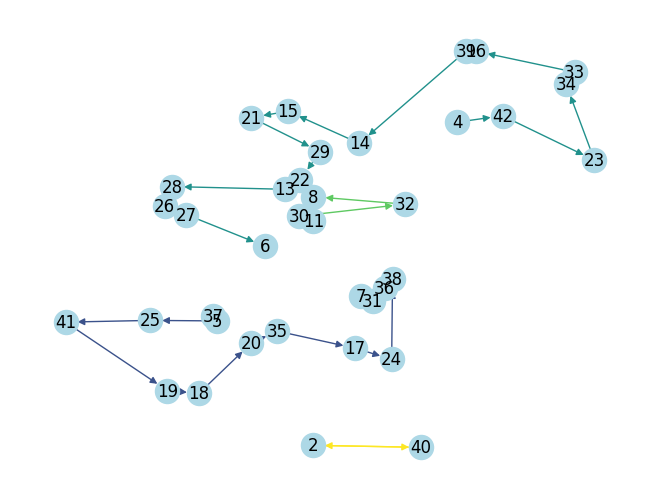

In [10]:
model.print_output()

In [14]:
model.x.display()

AttributeError: 'CVRPModel' object has no attribute 'x'